# Looking at SHAP values for an Additive model : sklearn's EBM (Explainable Boosting Machine)

In [21]:
import pandas
import sklearn
import interpret
import matplotlib
from sklearn import model_selection, linear_model, preprocessing, metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score, classification_report, confusion_matrix, mean_squared_error, mean_absolute_error
from interpret import glassbox
from interpret.glassbox import ExplainableBoostingRegressor
import numpy as np
import matplotlib.pyplot as plt

In [4]:
rxns_df = pandas.read_csv("godineau2023_reactions_with_yields.tsv", sep='\t')
rxns_df_x = rxns_df.drop("Yield of 3aa", axis = 1)
rxns_df_x = rxns_df_x.drop("Conversion of 1a", axis = 1)
rxns_df_y = rxns_df[["Yield of 3aa"]]

In [5]:
numerical_features = rxns_df_x.select_dtypes(include=['int','float']).columns
categorical_features = rxns_df_x.select_dtypes(include=['object']).columns
label_encoders={}
for feature in categorical_features:
    label_encoders[feature]=LabelEncoder()
    rxns_df_x[feature] = label_encoders[feature].fit_transform(rxns_df_x[feature])
#prepping y
numerical_features_y = rxns_df_y.select_dtypes(include=['int','float']).columns
categorical_features_y = rxns_df_y.select_dtypes(include=['object']).columns
label_encoders_y={}
for feature in categorical_features_y:
    label_encoders[feature]=LabelEncoder()
    rxns_df_y[feature] = label_encoders_y[feature].fit_transform(rxns_df_y[feature])
x_train, x_temp, y_train, y_temp = train_test_split(rxns_df_x, rxns_df_y, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5,random_state=42)

In [6]:
model = ExplainableBoostingRegressor(interactions=0)
model.fit(x_train, y_train)

ExplainableBoostingRegressor(interactions=0)

In [7]:
#validation
y_val_pred = model.predict(x_val)
#accuracy = model.score(y_val_pred, y_val)
accuracy = r2_score(y_val, y_val_pred)
print(f'Validation Accuracy with r2 :{accuracy}')
MAE_val = mean_absolute_error(y_val, y_val_pred)
RMSE_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
print(f"Validation RMSE:{RMSE_val}")
print(f'Validation MAE:{MAE_val}')

#testing
y_test_pred = model.predict(x_test)
accuracy_test = r2_score(y_test, y_test_pred)
#accuracy_test = model.score(y_test_pred, y_test)
print(f'Test Set Accuracy with r2 : {accuracy_test}')
MAE_test = mean_absolute_error(y_test, y_test_pred)
RMSE_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"Test RMSE:{RMSE_test}")
print(f'Test MAE:{MAE_test}')

Validation Accuracy with r2 :0.5962191079089076
Validation RMSE:12.991401671593556
Validation MAE:11.057603107977062
Test Set Accuracy with r2 : 0.5713134900454895
Test RMSE:14.101885510074048
Test MAE:11.148774929832925


In [ ]:
x_val

In [8]:
import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [9]:
explainer = shap.Explainer(model.predict, x_train)
shap_values = explainer(x_val)

Permutation explainer: 41it [00:24,  1.63it/s]                        


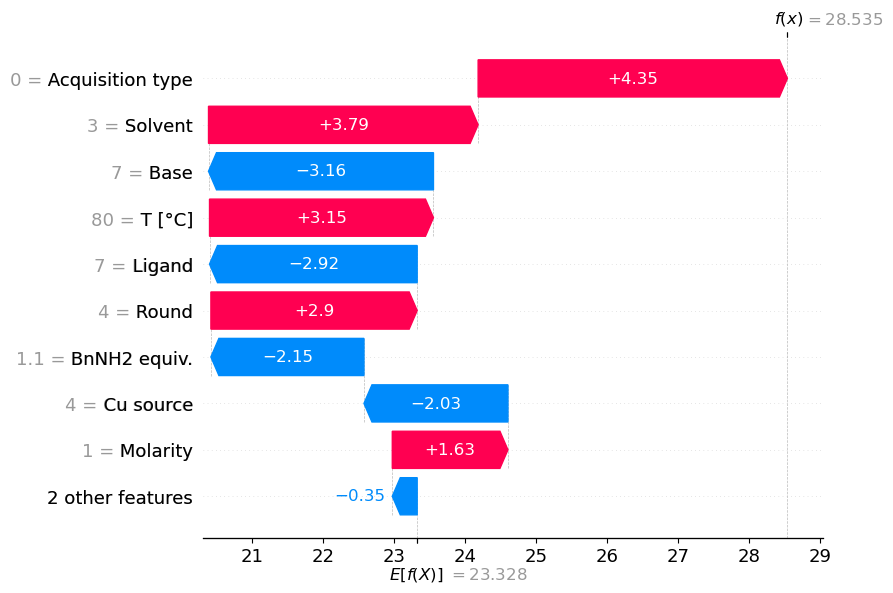

In [10]:
shap.plots.waterfall(shap_values[0], max_display=10)

The SHAP values of the features are different than the ones from the linear model. Most notably the base has a much higher SHAP value here than in the linear model where it was almost always in the bottom two.

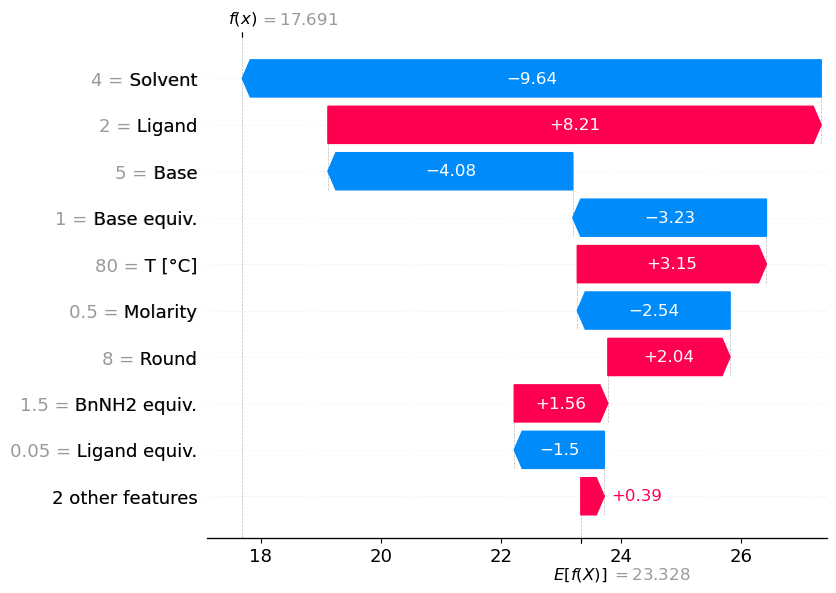

In [29]:
shap.plots.waterfall(shap_values[1], max_display=10)

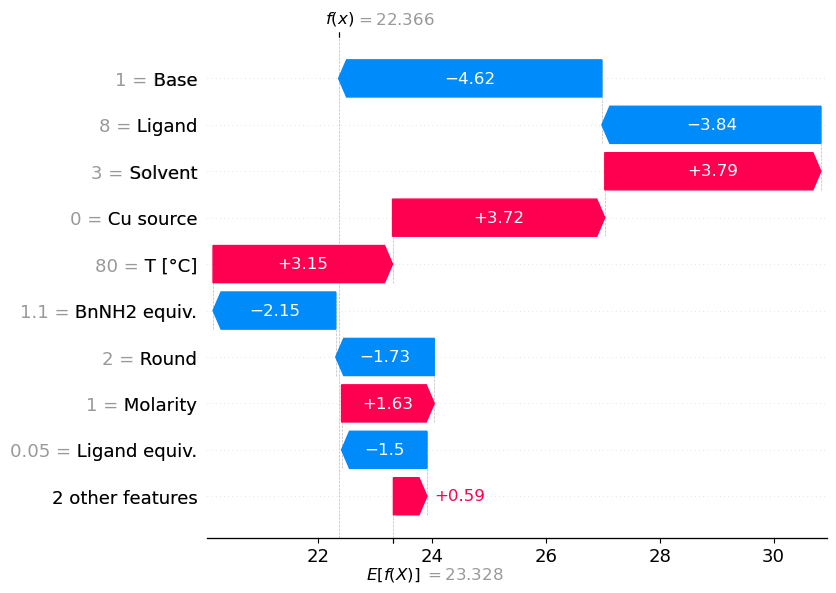

In [30]:
shap.plots.waterfall(shap_values[2], max_display=10)

This model is much less accurate in its predictions of the contribution of separate features than the linear regression however additively it predicts a more accurate yield. It's fitting considering the type of model it is.

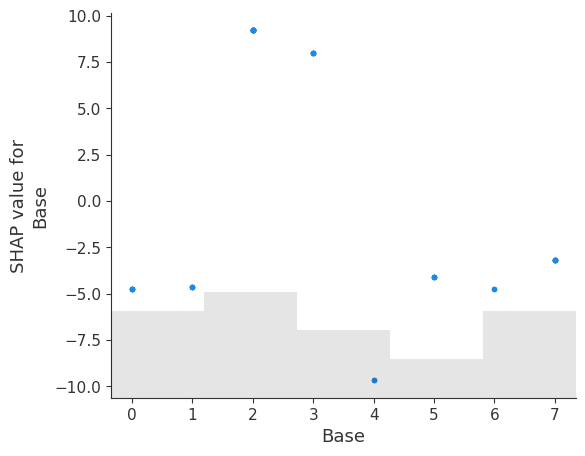

In [13]:
shap.plots.scatter(shap_values[:,"Base"])

Bases 2 and 3 (K3PO4 and K2CO3) lead to the highest yields as expected.

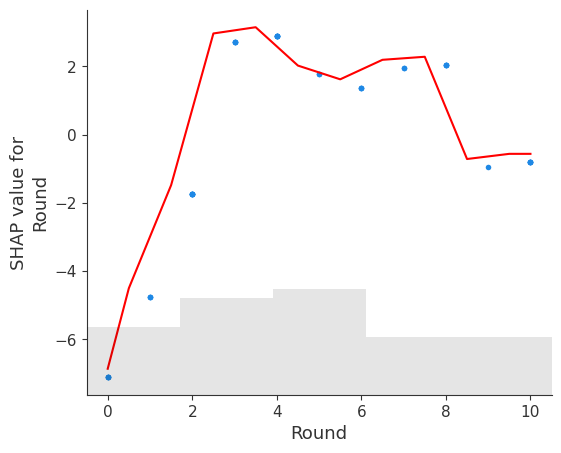

In [24]:
shap.plots.scatter(shap_values[:,"Round"], show=False)
# First get the index of the alcohol feature
idx = model.explain_global().data()['names'].index('Round')
# extract the relevant data from the tree-based GAM
explain_data = model.explain_global().data(idx)
# the alcohol feature values
x_data = explain_data["names"]
# the part of the prediction function for alcohol
y_data = explain_data["scores"]
y_data = np.r_[y_data, y_data[np.newaxis, -1]]
plt.plot(x_data, y_data, color='red')
plt.show()

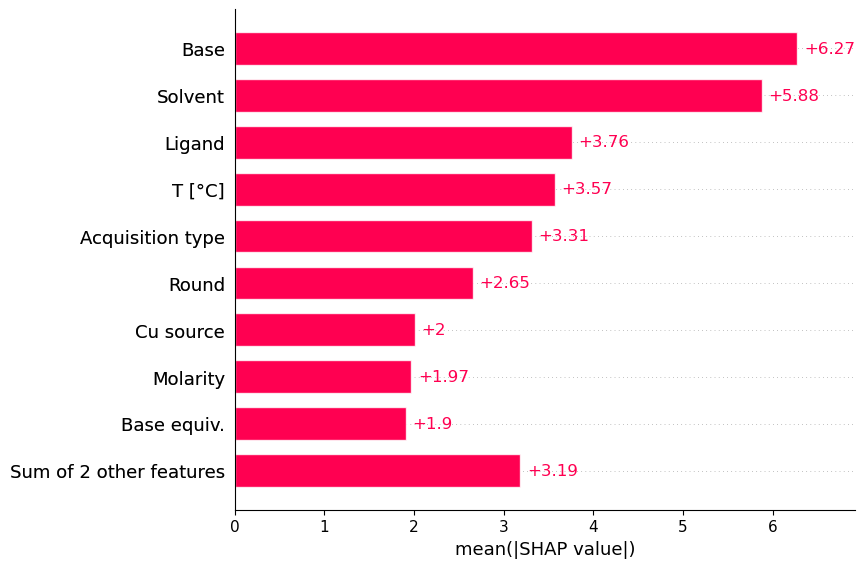

In [27]:
shap.plots.bar(shap_values)

In the GAM, the base has the highest SHAP value yet it is one of two with the lowest SHAP value in the linear model. It is also interesting to note the molarity also has a much higher SHAP value here than in the linear model. 

Here, the bottom two parameters are Ligand equivalent and BnNH2 equivalent which were two of the features with more significant SHAP values in the linear model.

A GAM is an additive model, which implies that we can inspect each feature in isolation to understand its effect without considering interaction effects. This is NOT the same as a linear regression which tries to find interactions between the different features while training. 

In the end, this model is more accurate than the linear regression in its prediction of the yields. By considering the features separately from each other and adding them up in the end, it reaches somewhat correct results. Still, we are looking at a set of chemical reactions where ultimately the interactions between the features are very important, which is why we'll need another model if we want to improve the results.